<a href="https://colab.research.google.com/github/GFDRR/dfcv-scan/blob/master/examples/demo2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# D-FCV Scan Tutorial

Welcome to the tutorial for the Disaster - Fragility, Conflict, and Violence (D-FCV) Scan!

D-FCV Scan is an open‑source, globally applicable toolkit for the rapid mapping and assessment of multi‑hazard and conflict exposure at subnational scales.

![title](https://github.com/GFDRR/dfcv-scan/blob/master/assets/figure.png?raw=true)

Our toolkit automates the download and processing of globally accessible asset, hazard, conflict, and displacement data, with the goal of mapping the spatial distribution of co-occurring multi-hazard and FCV exposure. Our work is designed to guide high-level, evidence-based DRM decision-making in FCV contexts and enable them to efficiently identify priority areas for more strategic resource allocation at the Disaster–FCV nexus.

## Table of Contents

1.    [Initialize Credentials](#initialize-credentials)
2.    [Download Data](#download-data)
3.    [Administrative Boundaries](#administrative-boundaries)
4.    [Asset Data Layers](#asset-data-layers)
5.    [Internal Displacement Data Layers](#internal-displacement-data-layers)
6.    [Conflict Data Layers](#conflict-data-layers)
7.    [Conflict Exposure](#conflict-exposure)
8.    [Hazard Data Layers](#hazard-data-layers)
9.    [Hazard Exposure](#hazard-exposure)
10.    [Multihazard Exposure Score](#multihazard-exposure-score)
11.    [Multihazard-Conflict Exposure Score](#multihazard-conflict-exposure-score)
12.    [Interactive Mapping](#interactive-mapping)




## Imports and Setup

After running the first cell, you will be prompted to restart the session. Hit `Restart session` and continue running the rest of the cells.

In [ ]:
%%time
!apt install gdal-bin
!pip install --index-url https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple/ dfcv-colocation-mapping==0.6.2

In [ ]:
%%time
!pip install ipywidgets==7.7.1
!jupyter nbextension enable --py widgetsnbextension

In [3]:
from dfcv_colocation_mapping import data_download
from dfcv_colocation_mapping import data_utils
from dfcv_colocation_mapping import map_utils
from dfcv_colocation_mapping import widgets

import re
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

from google.colab import output
output.enable_custom_widget_manager()

import warnings
import pprint
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore", message=r"datetime.datetime.utcnow")
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

<a name="initialize-credentials"></a>
# Initialize Credentials

## ACLED Credentials
ACLED data contains global information on conflict events collected by the Armed Conflict Location & Event Data Project (ACLED).

To access ACLED data:
1. Register at https://acleddata.com/.
2. Enter your ACLED credentials in the fields below.

The following cell will then automatically generate your ACLED API key and save it to the file `acled_cred.yaml`.

For more information on the ACLED API, please refer to [ACLED's API documentation](https://acleddata.com/api-documentation/getting-started).

In [4]:
acled_email = None # @param {type: "string"}
acled_password = None # @param {type: "string"}

acled_file = "acled_creds.yaml"
!curl -H 'Content-Type: multipart/form-data' \
      -F username={acled_email} \
      -F password={acled_password} \
      -F grant_type='password' \
      -F client_id='acled' \
      -X POST \
      'https://acleddata.com/oauth/token' \
      -o {acled_file}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   542    0    84  100   458    299   1630 --:--:-- --:--:-- --:--:--  1935


## IOM DTM Credentials

The International Organization for Migration (IOM) Displacement Tracking Matrix (DTM) gathers data on the mobility, vulnerabilities, and needs of displaced and mobile populations.

To access IOM DTM data:

1. Register at https://dtm.iom.int/data-and-analysis/dtm-api.
2. Go to `APIs` on the menu bar >> Search `API-V3` >> Subscribe to `API-V3`
3. Copy your `Primary key` into the field below.

In [10]:
dtm_key = "None" # @param {type: "string"}

## IDMC Credentials

To access IDMC data:
1. Request access by sending an email to ch.datainfo@idmc.ch with a brief description of how you plan to use the data.
2. Receive your API key If your request is approved, you will receive an API key via email.
3. Enter the API key in the field below.

For more information, refer to [IDMC's API documentation](https://www.internal-displacement.org/database/api-documentation/?).

In [11]:
idmc_key = "None" # @param {type: "string"}

<a name="download-data"></a>
# Download Data

To begin the download process, specify the [ISO 3166-1 alpha-3 Code](https://www.iso.org/obp/ui/#search) and [Administrative Level](https://www.geoboundaries.org/countryDownloads.html) for your country of interest below.

You may also specify the start and end dates for both conflict and displacement events. By default, the pipeline downloads data from the last 10 years.

🚨 **Important**: For larger countries, Colab's free tier may not be sufficient to run the analysis. Consider upgrading or using alternative, more powerful computing resources (16 to 32 GB RAM).

In [12]:
# @markdown ### Country Name and Admin Level
iso_code = "SLE (Sierra Leone)"  # @param ["ABW (Aruba)", "AGO (Angola)", "AIA (Anguilla)", "ARG (Argentina)", "ATG (Antigua and Barbuda)", "BDI (Burundi)", "BEN (Benin)", "BFA (Burkina Faso)", "BGD (Bangladesh)", "BHS (The Bahamas)", "BLM (Saint Barthelemy)", "BLZ (Belize)", "BOL (Bolivia)", "BRA (Brazil)", "BRB (Barbados)", "BRN (Brunei)", "BTN (Bhutan)", "BWA (Botswana)", "CAF (Central African Republic)", "CHL (Chile)", "CIV (Ivory Coast)", "CMR (Cameroon)", "COD (Democratic Republic of the Congo)", "COG (Republic of Congo)", "COL (Colombia)", "COM (Comoros)", "CPV (Cape Verde)", "CRI (Costa Rica)", "CUB (Cuba)", "CUW (Cura\u00e7ao)", "CYM (Cayman Islands)", "DJI (Djibouti)", "DMA (Dominica)", "DOM (Dominican Republic)", "DZA (Algeria)", "ECU (Ecuador)", "EGY (Egypt)", "ERI (Eritrea)", "ETH (Ethiopia)", "FLK (Falkland Islands)", "GAB (Gabon)", "GHA (Ghana)", "GIN (Guinea)", "GMB (Gambia)", "GNB (Guinea Bissau)", "GNQ (Equatorial Guinea)", "GRD (Grenada)", "GTM (Guatemala)", "GUY (Guyana)", "HND (Honduras)", "HTI (Haiti)", "IDN (Indonesia)", "IND (India)", "IOT (British Indian Ocean Territory)", "JAM (Jamaica)", "KEN (Kenya)", "KHM (Cambodia)", "KNA (Saint Kitts and Nevis)", "LAO (Laos)", "LBR (Liberia)", "LCA (Saint Lucia)", "LKA (Sri Lanka)", "LSO (Lesotho)", "MAF (Saint Martin)", "MDG (Madagascar)", "MDV (Maldives)", "MEX (Mexico)", "MOZ (Mozambique)", "MRT (Mauritania)", "MSR (Montserrat)", "MUS (Mauritius)", "MWI (Malawi)", "MYS (Malaysia)", "MYT (Mayotte)", "NAM (Namibia)", "NER (Niger)", "NGA (Nigeria)", "NIC (Nicaragua)", "NPL (Nepal)", "PAN (Panama)", "PER (Peru)", "PHL (Philippines)", "PRI (Puerto Rico)", "PRY (Paraguay)", "RWA (Rwanda)", "SDN (Sudan)", "SEN (Senegal)", "SGP (Singapore)", "SHN (Saint Helena)", "SLE (Sierra Leone)", "SLV (El Salvador)", "SOM (Somalia)", "SSD (South Sudan)", "STP (Sao Tome and Principe)", "SUR (Suriname)", "SWZ (Eswatini)", "SXM (Sint Maarten)", "SYC (Seychelles)", "TCA (Turks and Caicos Islands)", "TGO (Togo)", "THA (Thailand)", "TLS (East Timor)", "TTO (Trinidad and Tobago)", "TUN (Tunisia)", "TZA (United Republic of Tanzania)", "UGA (Uganda)", "URY (Uruguay)", "VCT (Saint Vincent and the Grenadines)", "VEN (Venezuela)", "VGB (British Virgin Islands)", "VIR (United States Virgin Islands)", "VNM (Vietnam)", "ZAF (South Africa)", "ZMB (Zambia)", "ZWE (Zimbabwe)"]
iso_code = re.sub(r'\([^)]*\)', '', iso_code).strip()
adm_level = "ADM3" # @param ["ADM1", "ADM2", "ADM3"]

# @markdown ---
# @markdown ### Conflict Start and End Dates
conflict_start_date = "2015-01-01" # @param {type: "date"}
conflict_end_date = "2025-01-01" # @param {type: "date"}

# @markdown ---
# @markdown ### Displacement Start and End Dates
displacement_start_date = "2015-01-01" # @param {type: "date"}
displacement_end_date = "2025-01-01" # @param {type: "date"}
# @markdown ---

dm = data_download.DatasetManager(
    iso_code,
    adm_level=adm_level,
    conflict_start_date=conflict_start_date,
    conflict_end_date=conflict_end_date,
    acled_cred_file=acled_file,
    dtm_key=dtm_key,
    idmc_key=idmc_key,
    displacement_start_date=displacement_start_date,
    displacement_end_date=displacement_end_date
)

## Optional: Filter ACLED Categories

The following cell demonstrates how to exclude (and include) specific event categories from ACLED data. A comprehensive description of the ACLED categories can be found in the [ACLED Codebook](https://acleddata.com/knowledge-base/codebook/).

By default, all ACLED categories are included in the conflict exposure calculation. To see which categories are included and excluded, run `dm.acled_filters`.

To customize which events are included in your analysis, use the `dm.set_acled_filters()` method.

  - `category`: The ACLED column to filter on (e.g., "disorder_type").
  - `values`: A list of comma-separated category values to include or exclude (please ensure the spelling is correct).
  - `operation`: Either "exclude" (remove this category) or "include" (keep or add back this category).

Note that when you exclude a disorder type, all corresponding event and sub-event types are also excluded. The same goes for event types and their corresponding sub-event type.

🚨 **Important:** Before proceeding, please make sure that the categories in the `include` and `exclude` dictionaries are correct and relevant with respect to your country's context.

In [13]:
# Define your save callback
asset_name = "worldpop" # @param ["worldpop", "bem", "worldcover_builtup", "worldcover_cropland"]

def save_selection(result):
    dm.acled_selected[asset_name] = result

# Create and show widget
ui = widgets.HierarchicalCheckboxes(
    dm.acled_hierarchy,
    selected_hierarchy=dm.acled_selected[asset_name],
    save_callback=save_selection,
    save_label="Save ACLED Selection"
)
ui.show()

## Download All Datasets

Commence full data download by running the `dm.download_all()`.
This function also calculates asset exposure to conflicts and hazards and aggregates the results to the specified administrative level.

You may also download and access the individual datasets as follows:

| Dataset  | Data Source | Category  |  Download Data | Access Data  |
|---|---|---|---|---|
| geoBoundaries  | https://www.geoboundaries.org/ | Admin Boundaries  | `dm.download_geoboundary("geoboundary")` | `dm.geoboundary`  |
| GADM  | https://gadm.org | Admin Boundaries  | `dm.download_geoboundary("gadm")` | `dm.geoboundary`  |
| ACLED  | https://acleddata.com | Conflict  | `dm.download_acled()` | `dm.acled`  |
| UCDP  | https://ucdp.uu.se  | Conflict  | `dm.download_ucdp()`  | `dm.ucdp`  |
| IOM DTM | https://dtm.iom.int/data-and-analysis/dtm-api  | Displacement |  `dm.download_dtm()` |  `dm.dtm` |
| IDMC GIDD Conflict |  https://www.internal-displacement.org/database |  Displacement | `dm.download_idmc_gidd(cause="conflict")`  | `dm.idmc_gidd_conflict`  |
| IDMC GIDD Disaster |  https://www.internal-displacement.org/database |  Displacement | `dm.download_idmc_gidd(cause="disaster")`  | `dm.idmc_gidd_disaster`  |
| OpenStreetMap |  https://www.openstreetmap.org | Point-of-Interest | `dm.download_osm()`  | `dm.osm`  |
| Fathom  |  https://www.fathom.global | Hazard | `dm.download_fathom()` | `dm.fathom`
| Hazards * | See [Section 8](#hazard-data-layers)  | Hazard | `dm.download_datasets(name="asset")`  | `dm.hazards`  |
| Assets * | See [Section 4](#asset-data-layers)  | Asset | `dm.download_datasets(name="hazard")`  | `dm.assets`  |


*Note that further details on the different asset and hazard datasets are described in later sections.




In [15]:
%%time
dm.download_datasets()
geoplot = map_utils.GeoPlot(dm)
dm.data.head(3)

INFO:root:Loading ADM3 geoboundaries...
INFO:root:Loading asset layers...
INFO:root:Loading hazard layers...
INFO:root:Loading conflict data from 2015-01-01 to 2025-01-01...
INFO:root:Loading ACLED data...
Processing bem: 100%|██████████| 4/4 [00:20<00:00,  5.15s/it]
INFO:root:Loading UCDP data...
Processing bem: 100%|██████████| 4/4 [00:00<00:00,  5.96it/s]
INFO:root:Loading displacement data from 2015-01-01 to 2025-01-01...
INFO:root:Loading IOM DTM data...
INFO:root:WARNING: No DTM data available for SLE (Sierra Leone).
INFO:root:Loading IDMC data...
INFO:root:Calculating Multihazard Scores...
INFO:root:Downloading OSM...


CPU times: user 20.7 s, sys: 2.53 s, total: 23.3 s
Wall time: 25.5 s


iso_code        ADM3                  ADM3_ID                  ADM2_ID      ADM2                  ADM1_ID     ADM1      worldpop  worldcover_builtup  worldcover_cropland         bem                                           geometry  earthquake  earthquake_worldpop_exposure  earthquake_worldpop_intensity_weighted_exposure  earthquake_worldcover_builtup_exposure  earthquake_worldcover_builtup_intensity_weighted_exposure  earthquake_worldcover_cropland_exposure  earthquake_worldcover_cropland_intensity_weighted_exposure  earthquake_bem_exposure  earthquake_bem_intensity_weighted_exposure  landslide_earthquake_gfdrr  landslide_earthquake_gfdrr_worldpop_exposure  landslide_earthquake_gfdrr_worldpop_intensity_weighted_exposure  landslide_earthquake_gfdrr_worldcover_builtup_exposure  landslide_earthquake_gfdrr_worldcover_builtup_intensity_weighted_exposure  landslide_earthquake_gfdrr_worldcover_cropland_exposure  landslide_earthquake_gfdrr_worldcover_cropland_intensity_weighted_exposure  \
0      SLE         Dea  93885176B98792258194007  92492822B60042663074056  Kailahun  64854884B13787310286412  Eastern  17551.541016                0.84                 0.00  30672944.0  POLYGON ((-10.60592 7.86858, -10.606 7.9059, -...    0.031345                           0.0                                              0.0                                     0.0                                                0.0                                              0.0                                                0.0                               0.0                                         0.0                         0.0                                           0.0                                                0.0                                                              0.0                                                     0.0                                                                        0.0                                                      0.0                            
1      SLE       Jawie  93885176B13617389848544  92492822B60042663074056  Kailahun  64854884B13787310286412  Eastern  66297.875000                3.27                 0.01  97842848.0  POLYGON ((-10.91103 7.7617, -10.90596 7.76577,...    0.028734                           0.0                                              0.0                                     0.0                                                0.0                                              0.0                                                0.0                               0.0                                         0.0                         0.0                                           0.0                                                0.0                                                              0.0                                                     0.0                                                                        0.0                                                      0.0                            
2      SLE  Kissi Kama  93885176B59602351582644  92492822B60042663074056  Kailahun  64854884B13787310286412  Eastern  22871.412109                0.78                 0.00  61869632.0  POLYGON ((-10.43962 8.33182, -10.43906 8.33032...    0.030818                           0.0                                              0.0                                     0.0                                                0.0                                              0.0                                                0.0                               0.0                                         0.0                         0.0                                           0.0                                                0.0                                                              0.0                                                     0.0                                                                        0.0                                                      0.0                           

<a name="administrative-boundaries"></a>
# Administrative Boundaries

A country's administrative boundaries are downloaded from either of the two sources:
- [geoBoundaries](https://www.geoboundaries.org/index.html)
- [GADM](https://gadm.org/)

By default, the pipeline attempts to download from **geoBoundaries**. If it fails after three attempts, it automatically falls back to GADM. To override this behavior and download directly from GADM, specify: `dm.download_all(adm_source="gadm")`.

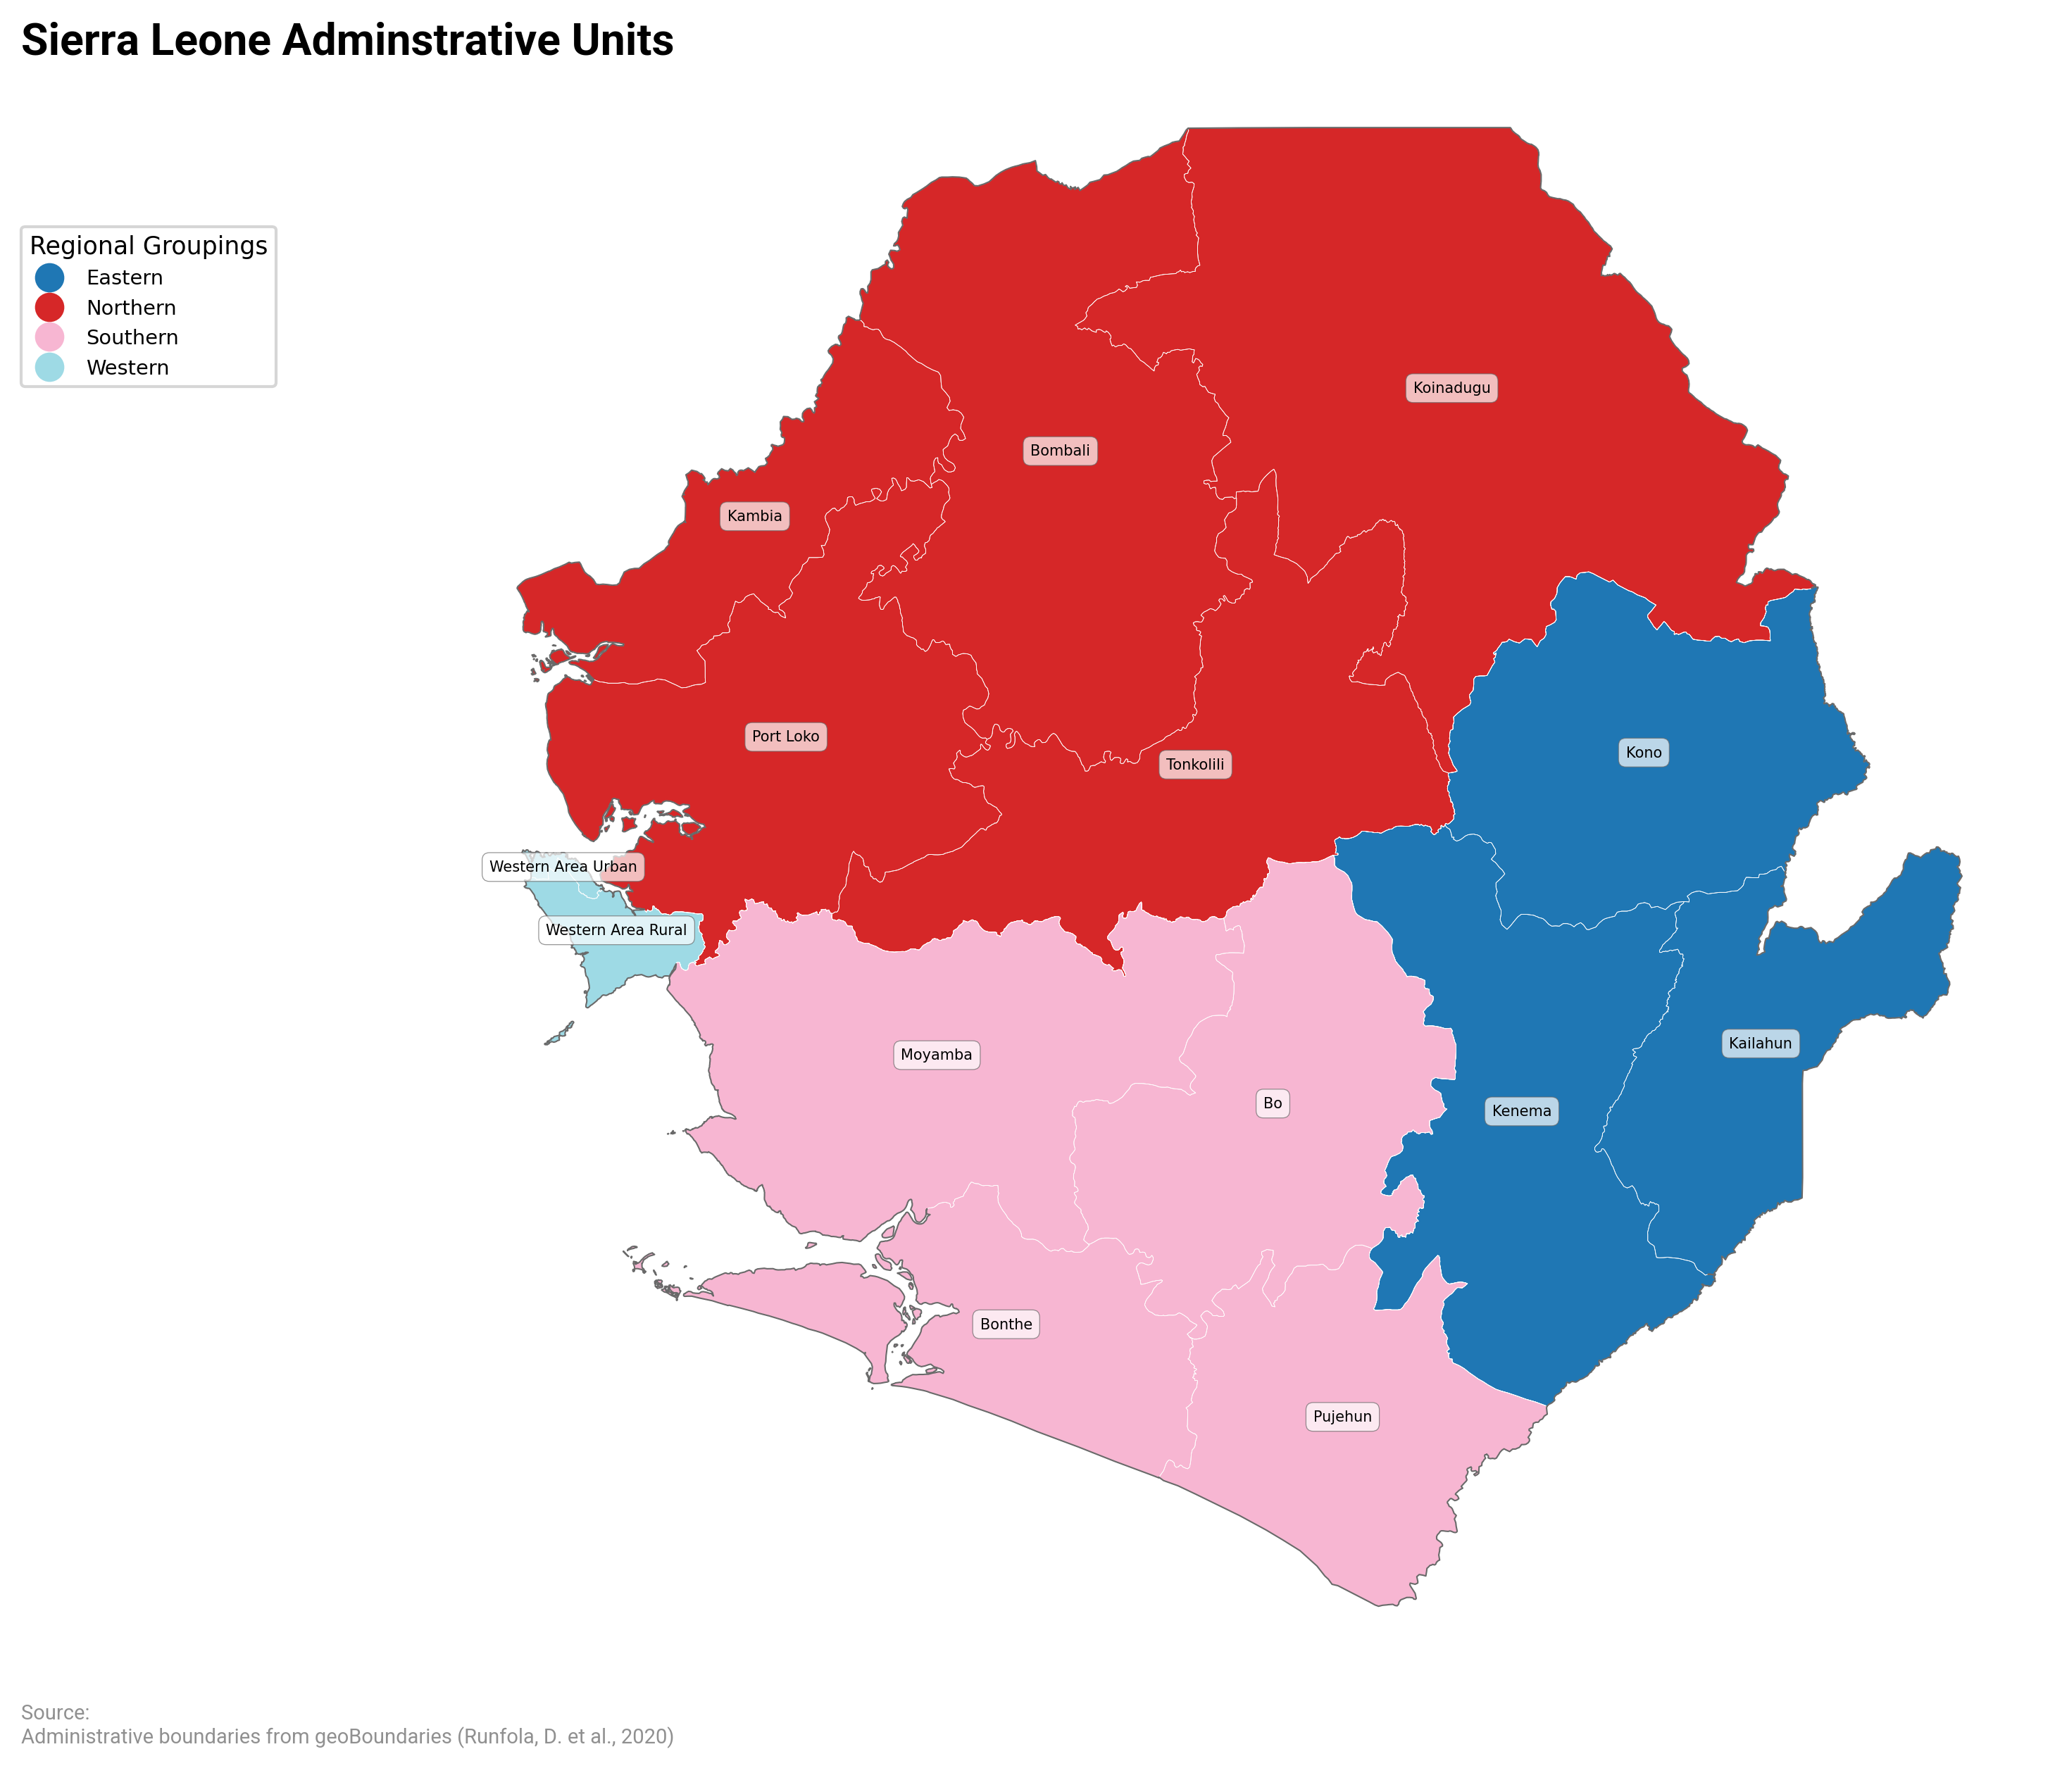

In [ ]:
# @title Plot Administrative Boundaries
group = "ADM1" # @param ["ADM1", "ADM2", "ADM3"]
adm_level = "ADM2" # @param ["ADM1", "ADM2", "ADM3", "ADM4"]

geoplot.plot_geoboundaries(
    adm_level=adm_level,
    group=group
);

<a name="asset-data-layers"></a>
# Asset Data Layers

We define **assets** as all people, infrastructure, and resources that could be negatively affected by a hazardous event.

For the asset datasets, you may choose among the following layers:

| Dataset | Variable Name | Data Source | Raster Resolution |  Unit (Aggregated) |
|---------|------|-------------|------|------|
| Population  |  worldpop   |     [WorldPop](https://hub.worldpop.org/geodata/listing?id=69)        | 100 m/px |   Number of people   |
| Building Exposure Model    |  bem    |     [Coalition for Disaster Resilient Infrastructure (CDRI)](https://giri.unepgrid.ch/map?view=MX-B7WR7-ZLQO2-J5OMQ)    | 5 km/px   |  US Dollar    |
| Worldcover - Builtup  * |  worldcover_builtup    |    [European Space Agency](https://esa-worldcover.org/en/data-access)        | 10 m/px |  Squared kilometers ($km^2$)   |
| Worldcover - Cropland *  |  worldcover_cropland    |    [European Space Agency](https://esa-worldcover.org/en/data-access)         | 10 m/px |  Squared kilometers ($km^2$)   |


All raster datasets are aggregated to the specified administrative level using simple summation of values.

*Note that Worldcover was chosen over other global land cover datasets (e.g., ESRI LULC, Dynamic World, GLAD GLC) based on [this comparative analysis by the Land & Carbon Lab](https://landcarbonlab.org/insights/global-land-cover-maps-accuracy-applications/).

🚨 **Important**: For the purpose of computational efficiency, we resampled the 10m Worldcover datasets to to 100m using nearest neighbor interpolation. This resampling to a lower resolution may lead to some loss in accuracy.

You can override this configuration by setting `dm.resample_worldcover = False` prior to commencing data download. However note that  this may lead to longer processing times and may require more powerful computational resources.

📝 **TODO**: Incorporate additional asset datasets from World Settlement Footprints (WSF), Global Human Settlement Layer (GHSL), etc.

In [ ]:
widget = widgets.ChoroplethWidget(
    dm=dm,
    geoplot=geoplot,
    var_list=dm.asset_names,
    default_var="worldpop",
    var_label="Asset:",
)
widget.show()

Output()

<a name="internal-displacement-data-layers"></a>
# Internal Displacement Data Layers
**Internally Displaced Persons (IDPs)** are individuals or groups who have been forced to leave their homes due to conflict, violence, human rights violations, or disasters but remain within their own country's borders.

We use two main sources for displacement data:
- [IOM Displacement Tracking Matrix (DTM)](https://dtm-apim-portal.iom.int/documentation)
- [IDMC Global Internal Displacement Database (GIDD)](https://www.internal-displacement.org/database/)

For both datasets, we report the total number of reported IDPs within the user-specified start and end dates, aggregated to the specified adminstrative level.

For the IOM DTM dataset, we limit the dataset to the reported IDP figures within the **latest round** of the survey for the latest year within the user-specified start and end dates. By default, `dm.dtm` returns the full DTM dataset. To access the filtered dataset, use `dm.dtm_filtered`.

For the IDMC GIDD datasets, data is disaggregated by conflict and disaster, as denoted in the `idmc_conflict_idp_total` and `idmc_disaster_idp_total` columns, respectively.


In [ ]:
widget = widgets.ChoroplethWidget(
    dm=dm,
    geoplot=geoplot,
    var_list=[
        "dtm_idp_total", "idmc_idp_total",
        "idmc_conflict_idp_total", "idmc_disaster_idp_total"
    ],
    default_var="idmc_idp_total",
    var_label="Displacement Var:",
)
widget.show()

Output()

<a name="conflict-data-layers"></a>
# Conflict Data Layers

We use two main sources for the conflict data layers:
- [ Armed Conflict Location & Event Data (ACLED) Project](https://acleddata.com/)
- [Uppsala Conflict Data Program (UCDP)](https://ucdp.uu.se/)

We calculate the total number of conflicts and fatalities, as well as number of fatalities per conflict, with each administrative unit.

ACLED categories are filtered based on the inclusion and exclusion criteria (see previous Section X). Use `dm.acled_filters` to see which ACLED categories are included/excluded.

In [ ]:
widget = widgets.ChoroplethWidget(
    dm=dm,
    geoplot=geoplot,
    enable_conflict=True
)
widget.show()

Output()

<a name="conflict-exposure"></a>
# Conflict Exposure

We calculate conflict exposure as a function of asset and conflict data.

<center>$\text{exposure}_{\text{conflict}} = f(\text{asset}, \text{conflict})$ </center>

We overlay asset data with conflict events, buffered by a radius depending on the conflict event type. All assets that fall within the conflict buffer zones are considered exposed. Finally, we aggregate the exposure at the level of the specified administrative unit.

### Conflict Exposure Aggregation
We apply two different **conflict exposure aggregation methods**:
- **Absolute exposure**: the sum of the exposed asset
- **Relative exposure**: ratios or share of the exposure
from the total assets within the admin unit


<details>
<summary>ACLED Conflict Exposure Calculation</summary>

We provide two ways to calculate conflict exposure from ACLED:

#### **A. Using the `population_best` estimates provided by ACLED.**
> ACLED includes a best estimate of conflict-exposed populations based on the author's knowledge of the impact and intensity of different ACLED event types. The "best" estimate is based solely on a general rule for event types and whether at least one fatality occurred. ([Source](https://acleddata.com/platform/conflict-exposure-calculator))

The default measures that comprise the best estimate are:

| Event types | Radius |
|-------------|--------|
| Battles     |     5 km   |
| Explosions/remote violence            |     5 km   |
| Violence against civilians with no reported fatality            |   2 km     |
| Violence against civilians with at least one reported fatality            |     5 km   |
| Riots            |    2 km    |
| Strategic developments            |    N/A    |


The conflict exposure is calculated as:
<center> $\text{exposure}_{\text{conflict}} = \frac{\sum_i^N{\text{population_best}_i}}{N}$ </center>
where $N$ is the total number of conflicts.

🚨 Disadvantages of this approach:
- Conflict exposure values can have values greater than the total population for a given admin unit.
- Doesn't take into account whether or not conflicts events (and exposed populations overlap), leading to potential over/undercounting.

#### **B. Using **custom calculation** by the World Bank Group D-FCV Team (denoted by `wbg_acled`)**

The steps are as followed:
1. Buffer each conflict event by a radius based on ACLED event type and fataility occurrence, as specified in item A.
2. Get the union of all conflict regions within each admin unit and generate a conflict raster.
3. Overlay the conflict regions with the asset raster to get total conflict exposure per admin unit.

✅ This approach attemps to solve the issues in item A by:
- Ensuring that all conflict exposure values are $\leq$  the total population per admin unit
- Avoiding double-counting population in overlapping conflict areas
- Ensuring all affected populations are captured  across non-overlapping regions
</details>

In [ ]:
widget = widgets.ChoroplethWidget(
    dm=dm,
    geoplot=geoplot,
    enable_exposure=True,
    enable_conflict_exposure=True
)
widget.show()

Output()

<a name="hazard-data-layers"></a>
# Hazard Data Layers
**Hazard data layers** are geospatial datasets that depict the spatial extent and severity of potential hazards to help users understand risk and plan responses.

For the hazard datasets, we integrated the following layers:

| Dataset | Data Source |  Unit |
|---------|------|:------:|
| Earthquake |  [Global Earthquake Model](https://www.globalquakemodel.org/product/global-seismic-hazard-map)   |       Peak Ground Acceleration (PGA)   |     |
| Earthquake-triggered Landslide |   [GFDRR Global Landslide Hazard Map](https://datacatalog.worldbank.org/search/dataset/0037584)  |       Mean avg annual frequency    |    |
| Rainfall-triggered Landslide | [GFDRR Global Landslide Hazard Map](https://datacatalog.worldbank.org/search/dataset/0037584)     |       Mean avg annual frequency   |     |
| Cyclone |  [Coalition for Disaster Resilient Infrastructure (CDRI)](https://giri.unepgrid.ch/map?view=MX-HQYK4-ZSD45-28FOH)   |       km/h   |     |     
| Drought |  [NOAA/NCEI Standardized Precipitation Evapotranspiration Index (SPEI)](https://www.drought.gov/data-download)   |      SPEI   |     |     
| Heat Stress |  [A Global Monthly 1 km Universal Thermal Climate Index Dataset (GloUTCI-M)](https://zenodo.org/records/8310513)   |       degrees Celsius (°C)   |     |     
| Fluvial Flood |   [Coalition for Disaster Resilient Infrastructure (CDRI)](https://giri.unepgrid.ch/map?view=MX-6FLW2-W3L51-SNGTU)  |       cm   |     |
| Wildfire |  [Global Wildfire Information System (GWIS)](https://gwis.jrc.ec.europa.eu/applications/data-and-services)   |       Fire Weather Index (FWI)  |     |     


### Fathom Data
To access Fathom flood data layers, please send a request to mamadio@worldbank.org.

Once you've received the dataset, download+unzip the files in `data/<ISO>/`, and run `dm.download_fathom()`.

📝 **TODO**: Add information on the spatial resolutions of the rasters.

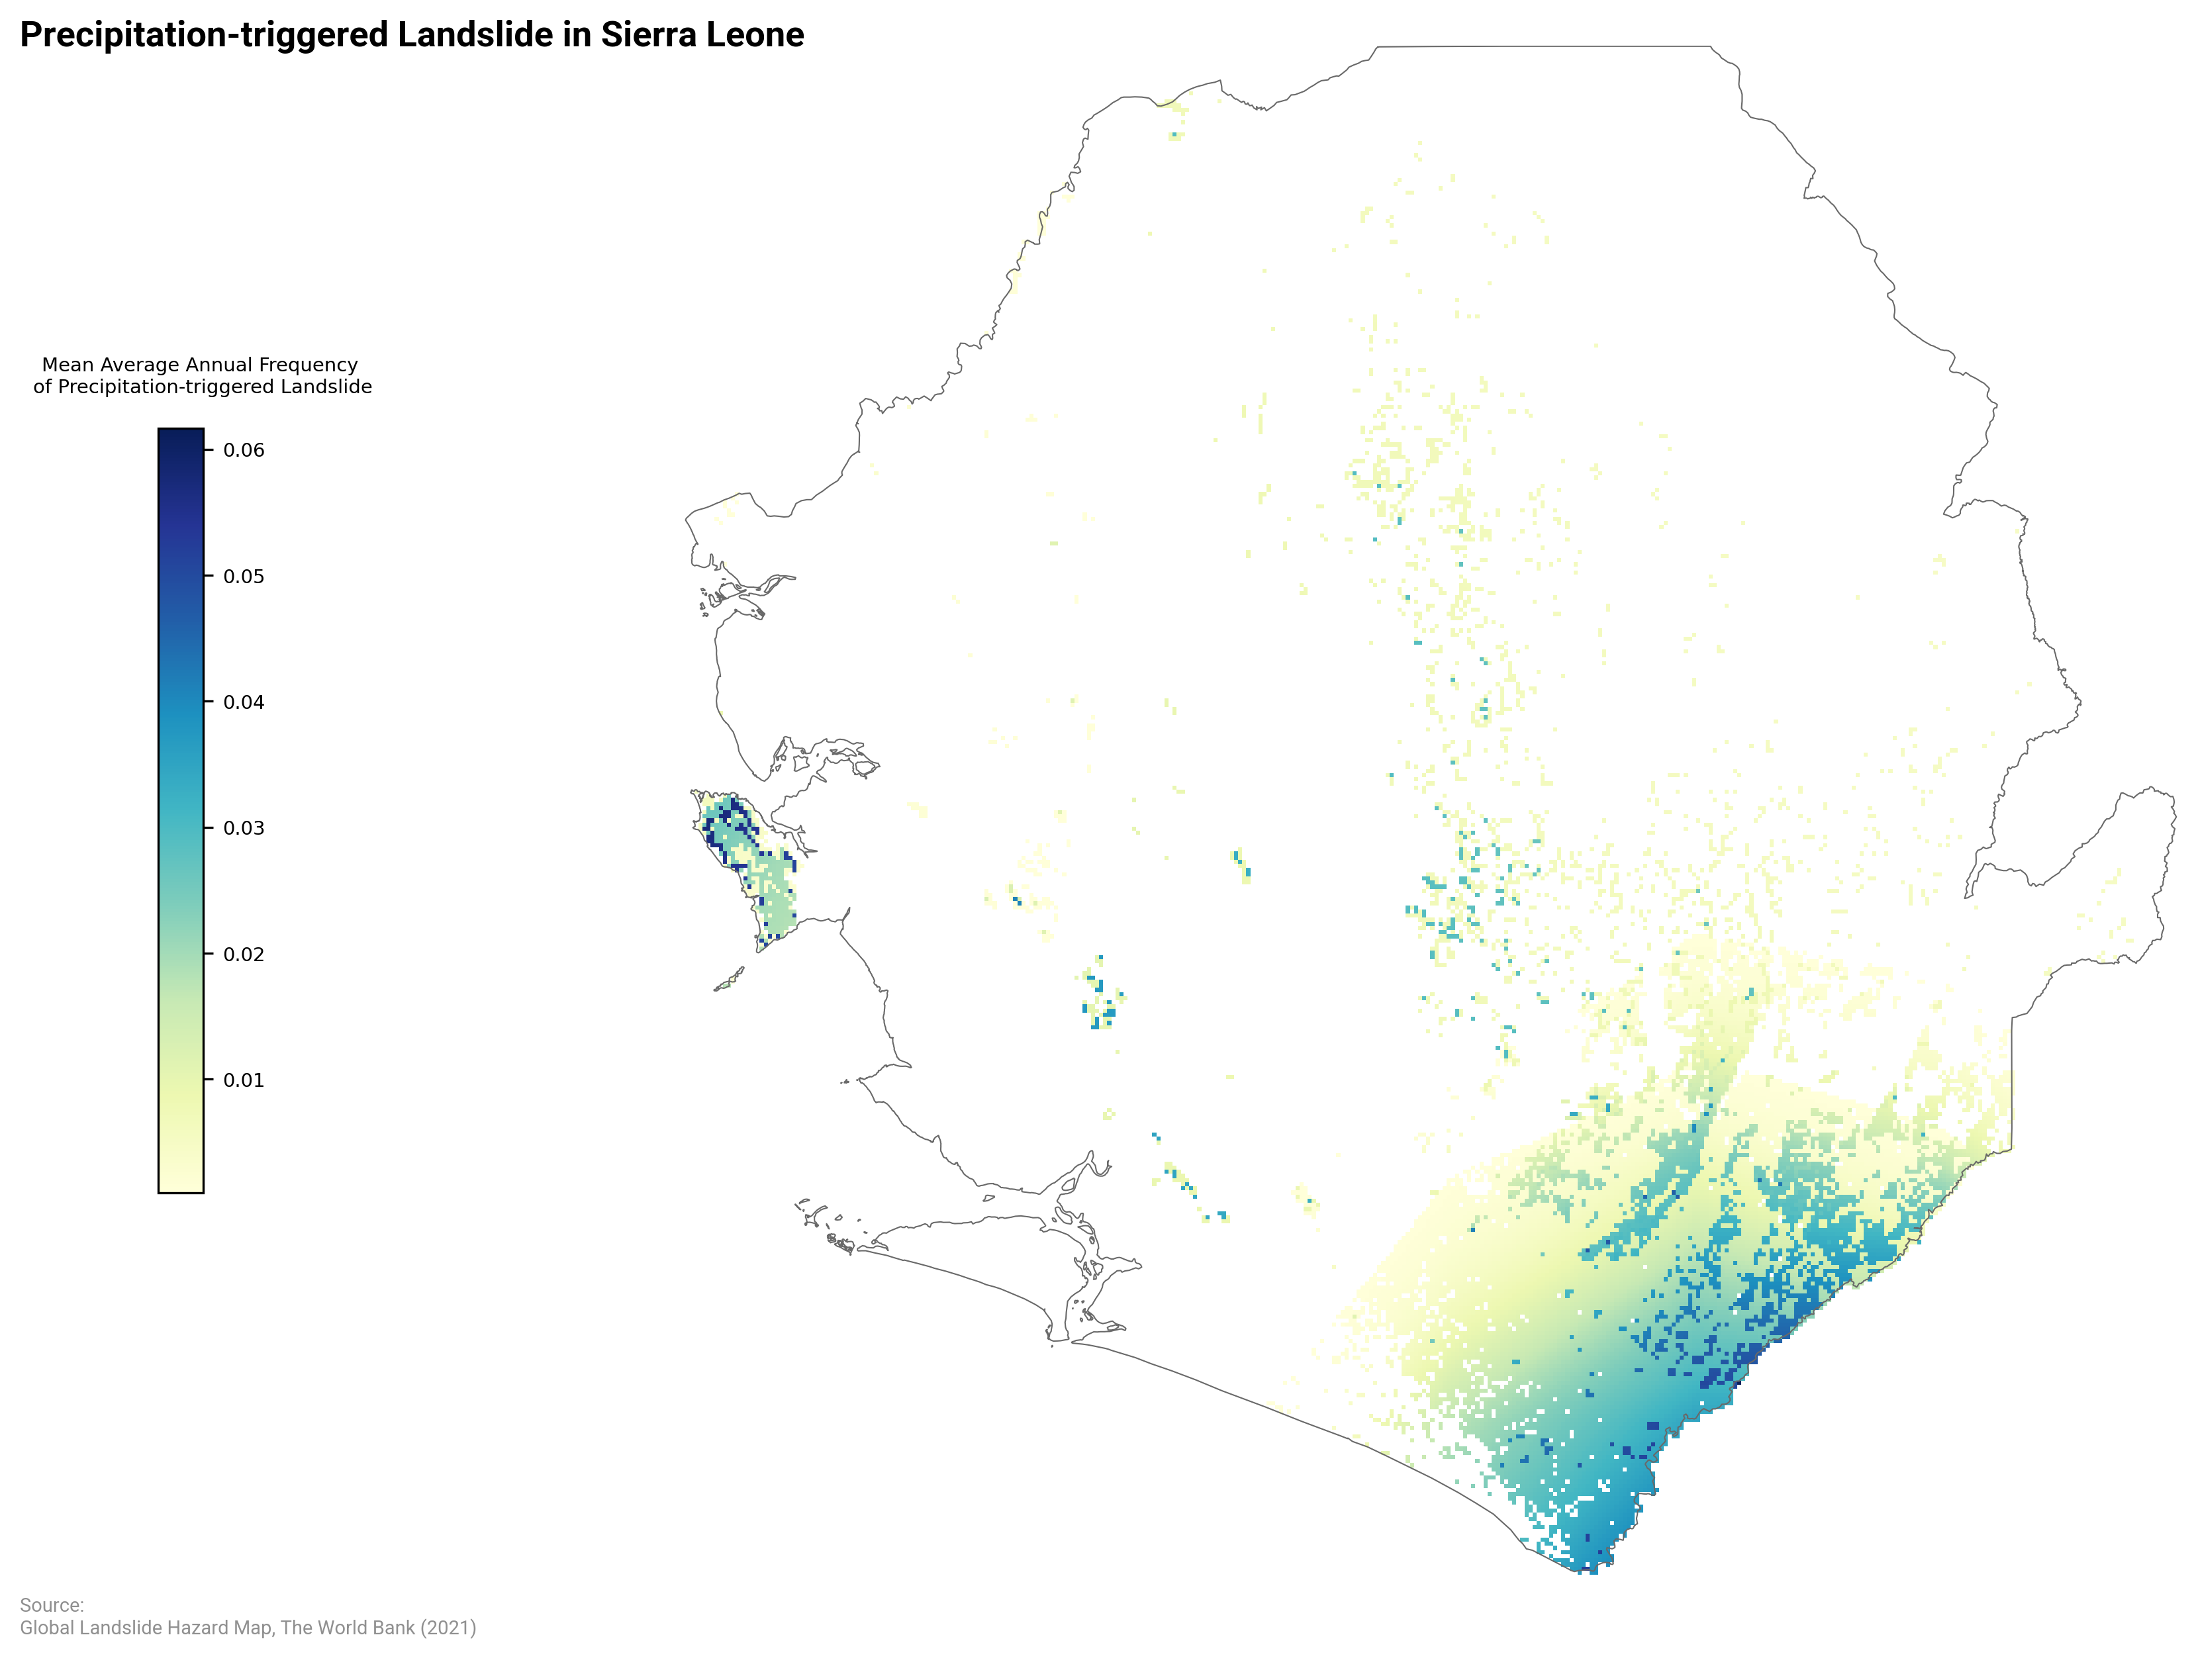

In [ ]:
# @title Plot Hazard Raster
hazard = "landslide_precip_gfdrr" # @param ["earthquake", "landslide_earthquake_gfdrr", "landslide_precip_gfdrr", "cyclone", "drought_spei", "heat_stress", "fluvial_flood_cdri", "wildfire"]
ax = geoplot.plot_raster(hazard);

<a name="hazard-exposure"></a>
# Hazard Exposure

We calculate calculate exposure as a function of asset and hazard data.

<center>$\text{exposure}_{\text{hazard}} = f(\text{asset}, \text{hazard})$ </center>

Exposure is defined by a hazard intensity threshold: when this threshold is exceeded, an asset is considered exposed. Whenever possible, we align these thresholds with authoritative classifications of hazard severity (see details below). Assets falling into medium and high severity categories are considered exposed.

| Dataset | Threshold |  Source |
|---------|:------:|:------:|
| Earthquake |   0.18g  |   [Instrumental Intensity Scales for Geohazards](https://dc.engconfintl.org/cgi/viewcontent.cgi?article=1015&context=geohazards)   
| Earthquake-triggered Landslide | 0.001 |  [GFDRR](https://datacatalog.worldbank.org/search/dataset/0037584)
| Rainfall-triggered Landslide | 0.001 | [GFDRR](https://datacatalog.worldbank.org/search/dataset/0037584)
| Cyclone | 119 km/h | [NOAA Tropical Cyclone Classification]( https://www.noaa.gov/jetstream/tropical/tropical-cyclone-introduction/tropical-cyclone-classification)
| Drought |  -1 | [Wang et al., 2021](https://essd.copernicus.org/articles/13/331/2021/)
| Heat Stress |  32°C | [NOAA National Weather Service](https://www.weather.gov/ffc/hichart)
| Fluvial Flood |  30 cm | [NOAA National Weather Service](#https://www.weather.gov/media/directives/010_pdfs/pd01001003a012018curr.pdf)
| Wildfire | 11.2 | [GWIS](https://gwis.jrc.ec.europa.eu/about-gwis/technical-background/fire-danger-forecast)


We overlay the asset layers with hazard maps to determine the extent of the assets exposed to each hazard. Note that all hazard layers are resampled using GDAL to match the spatial resolution of the asset layers of interest using nearest neighbor interpolation.

### Hazard Exposure Aggregation
As with with conflict exposure, we calculate both **absolute** and **relative** exposure. However, while relative exposure is useful for showing the share of assets or populations exposed, it does not reflect variations in the severity of exposure.

To address this, we introduce the **Intensity-weighted Relative Exposure Indicator**, which factors in hazard severity:

<center>$\text{Relative exposure} × \text{Normalized hazard intensity}$ </center>

💡 Tip: In most cases, relative exposure is enough. Use the intensity-weighted version when the entirety of assets are exposed (e.g., a whole country to earthquakes) but you want to highlight which regions face stronger hazard levels.

📝 **TODO**: Use different interpolation methods for resampling (bilinear, cubic).

In [16]:
widget = widgets.ChoroplethWidget(
    dm=dm,
    geoplot=geoplot,
    enable_exposure=True,
    enable_hazard_exposure=True
)
widget.show()

Output()

<a name="multihazard-exposure-score"></a>
# Multihazard Exposure Score

The multihazard exposure score combines exposure to multiple hazards into a single metric. We provide several different approaches to aggregating hazard exposure indicators, namely:
- Weighted Arithmetic Mean
- Weighted Geometric Mean
- Weighted Generalized (or Power) Mean

See footnotes below for more details on the different multihazard score aggregation methods.

We also provide groupings of hazards based on the [EM-DAT Classification System](https://doc.emdat.be/docs/data-structure-and-content/glossary/).

| Dataset | EM-DAT Classification |
|---------|:----:|
| Earthquake |    Geophysical
| Earthquake-triggered Landslide | Geophysical
| Rainfall-triggered Landslide | Hydrological
| Fluvial Flood | Hydrological
| Cyclone | Meteorological
| Heat Stress | Meteorological
| Drought |  Climatological
| Wildfire | Climatological

Hazard classification definitions are further detailed in the footnotes.


<details>
<summary>Multihazard Score Aggregation Methods</summary>

### 1. Weighted Arithmetic Mean

<center>
$ M_j^{\text{arith}} = \frac{\sum_{m=1}^M w_m X_{mj}}{\sum_{m=1}^M w_m} $
</center>

where $X_{mj}$ is the exposure indicator for hazard $m$ at admin unit $j$ and $w_m$ is the weight of hazard $m$ (set to 1, for now).

Additive aggregation is often sensitive to outliers. A single extreme hazard can dominate the score, even if exposure to other hazards is low.

### 2. Weighted Geometric Mean
<center>
$M_j^{\text{geom}} = \left( \prod_{m=1}^M X_{mj}^{w_m} + \epsilon \right)^{1/\sum_{m=1}^M w_m}$
</center>

Here, we add a very small constant
$\epsilon$ (e.g., 0.0001), ensuring that zero individual hazard exposure values reduce the overall score but do not collapse it to zero.

This better captures compounding hazards, but is very sensitive to low values, i.e., just one small exposure can drag down the overall score, even if other hazards are high.

### 3. Weighted Generalized (or Power) Mean
<center>
$M_j^{\text{gen}} = \left( \frac{\sum_{m=1}^M w_m X_{mj}^{p}}{\sum_{m=1}^M w_m} \right)^{1/p}$
</center>

The parameter $p$ controls how the **weighted generalized mean** balances low vs. high hazard values:

- **Smaller \($p$ < 1\):** emphasizes lower values; approaches the geometric mean as \($p$ approaches 0\).  
- **Larger \($p$ \geq 1\):** emphasizes higher values, with \($p$ = 1\) equal to the arithmetic mean.  

By tuning \($p$\) (e.g., \(p = 0.5\)), you can avoid extremes, preventing very low values from suppressing the score while also stopping a single high value from dominating.
</details>

<details>
<summary>EM-DAT Hazard Classification Definitions</summary>

- **Climatological Hazards**: A hazard caused by long-lived, meso- to macro-scale atmospheric processes ranging from intra-seasonal to multi-decadal climate variability.
- **Geophysical Hazards**: A hazard originating from solid earth. This term is used interchangeably with the term geological hazard.
- **Hydrological Hazards**: A hazard caused by the occurrence, movement, and distribution of surface and subsurface freshwater and saltwater.
- **Meteorological Hazards**: A hazard caused by short-lived, micro- to meso-scale extreme weather and atmospheric conditions that last from minutes to days.

</details>

📝 TODO: Provide functionality for combining different hazard groups (e.g. Hydro-Met).

In [17]:
widget = widgets.ChoroplethWidget(
    dm=dm,
    geoplot=geoplot,
    enable_exposure=True,
    enable_mhs_exposure=True
)
widget.show()

Output()

<a name="multihazard-conflict-exposure-score"></a>
# Multihazard-Conflict Exposure Score

**Multi-hazard conflict exposure** combines conflict exposure with hazard exposure to highlight areas facing both risks simultaneously.  
It is calculated as the product of the two:  

$$
\text{Multihazard-Conflict Exposure} = \text{norm(Conflict Exposure)} \times \text{norm(Multihazard Exposure Score)}
$$

where $\text{norm}(x)$ denotes min–max normalization of variable
$x$ to the range $[0, 1]$ (e.g. using min-max scaling).

In [19]:
widget = widgets.ChoroplethWidget(
    dm=dm,
    geoplot=geoplot,
    enable_exposure=True,
    enable_conflict_exposure=True,
    enable_mhs_exposure=True
)
widget.show()

Output()

Alternatively, we can visualize multihazard and conflict exposure using a **bi-variate choropleth**, which has the added advantage of being able to highlight areas that are high in one variable (e.g., conflict) but low in the other.

In [20]:
widget = widgets.BivariateChoroplethWidget(dm, geoplot, data_utils)
widget.show()

Output()

<a name="interactive-mapping"></a>
# Interactive Mapping

Lastly, we demonstrate examples on how to generate interactive HTML maps for your analysis using Folium and KeplerGL.

In [ ]:
# @title Interactive Mapping with Folium
map = geoplot.plot_folium(
    adm_level="ADM3",
    var="worldpop",
    kwargs={"zoom_start": 7}
)
map

In [ ]:
 # @title Save Folium Map
 map.save(f'{dm.iso_code}_folium_map.html')

In [ ]:
# @title Interactive Mapping with KeplerGL
ui = widgets.KeplerMapUI(dm)
ui.show()